Importing the libraries

In [89]:
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

Read data file

In [90]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
clf = LinearRegression()

Add dummies, remove double features

In [91]:
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','appCat.office_sum_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]



In [92]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)

In [109]:
selector = RFECV(clf, step=1,cv=10,scoring='r2')
selector.fit(relevant,goldY)


RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [110]:
new_features = []
for bool, feature in zip(selector.get_support(), relevant.columns.values):
    if bool:
        new_features.append(feature)
print(new_features)

['appCat.office_sum_time_2', 'appCat.office_sum_time_3', 'appCat.finance_sum_time_4', 'mood_mean_time_5', 'appCat.finance_sum_time_5', 'lastTimeSeenMood_4']


In [111]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

scores = cross_validate(clf, relevant[new_features], goldY, cv=7,scoring=scoring)
print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


R2: 0.23 (+/- 0.17)
MSE: -0.42 (+/- 0.28)
EXPLAINED VARIANCE: 0.24 (+/- 0.20)


Evaluate on real test set

In [112]:
clf.fit(relevant[new_features], goldY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [115]:
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)
dfTest = dfTest.fillna(0)


MAE
0.49397665311118405
MSE
0.5198923766414048
RMSE
0.7210356278585718
R2
-0.0033137822969990793


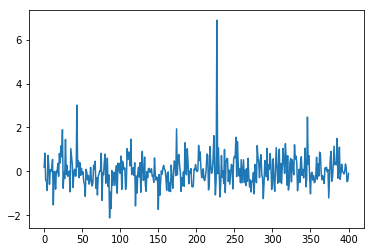

[('appCat.office_sum_time_2', -6.354247868575924), ('appCat.office_sum_time_3', 6.3854708416407195), ('appCat.finance_sum_time_4', -2.240262012908037), ('mood_mean_time_5', 3.001465113640814), ('appCat.finance_sum_time_5', 2.419721733663999), ('lastTimeSeenMood_4', -12.059458333472683)]


In [116]:
y_pred =clf.predict(dfTest[new_features])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))

import matplotlib.pyplot as plt
plt.plot(y_pred-dfTest['mood_mean_TARGET'])
plt.show()

print(list(zip(new_features,clf.coef_)))
allTogether = pd.concat([dfTest['mood_mean_TARGET'],dfTest[new_features]],axis=1)
allTogether['y_pred'] = y_pred
allTogether.to_csv("pred.csv")